## Chapter 27: Optimization

In [4]:
using Plots, Revise, PGFPlotsX
pgfplotsx()

Plots.PGFPlotsXBackend()

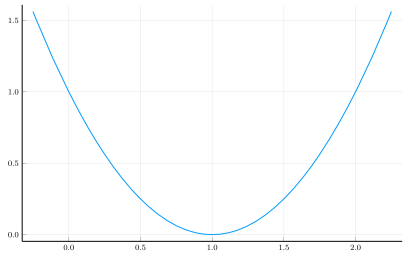

In [5]:
plot(x->(x-1)^2,-0.25,2.25,legend=false)

In [6]:
includet("Rootfinding.jl")
using .Rootfinding, ForwardDiff, LinearAlgebra

In [7]:
f(x)=(x-1)^2

f (generic function with 1 method)

In [8]:
newton(f,0)

The root was not found within 10 steps.
Currently, the root is approximately x̂ = 0.9990234375 
An estimate for the error is -0.00048828125
with f(x̂) = 9.5367431640625e-7


In [9]:
newton(x->ForwardDiff.derivative(f,x),0)

The root is approximately x̂ = 1.0
An estimate for the error is 0.0
with f(x̂) = 0.0
which took 1 steps

In [10]:
g(x::Vector) = x[1]^2+x[2]^2

g (generic function with 1 method)

In [11]:
ForwardDiff.gradient(g,[3,3])

2-element Array{Int64,1}:
 6
 6

In [12]:
rose(x::Vector) = (1-x[1])^2+50*(x[2]-x[1]^2)^2

rose (generic function with 1 method)

In [13]:
ForwardDiff.gradient(rose,[-0.5,0.5])

2-element Array{Float64,1}:
 22.0
 25.0

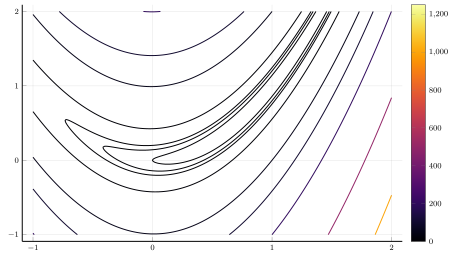

In [15]:
xrange = LinRange(-1,2,251)
yrange = LinRange(-1,2,251)
p2 =  plot(xrange,yrange,(x,y)->rose([x,y]),st = :contour,levels=[1,2,3,10,50,100,200,500,1000])
plot!(map(pt->pt[1],pts),map(pt->pt[2],pts),legend=false)

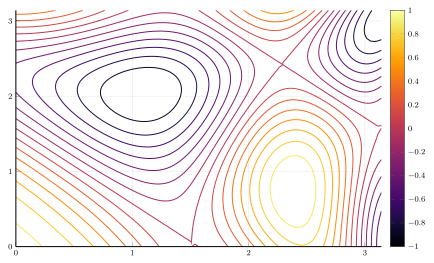

In [16]:
x = y = LinRange(0,pi,101)
f(x) = sin(0.5x[1]^2-0.25x[2]^2+2)*cos(x[1]+x[2])
cont = contour(x,y,(x,y)->f([x,y]))

In [14]:
savefig(cont,"contour.tex")

In [17]:
function gradientDescent(f::Function,x₀::Vector; γ = 0.25, max_steps = 100)
  local steps = 0
  local ∇f₀ = [1,1] # initialize it to get into while loop
  while norm(∇f₀)> 1e-8 && steps < max_steps
    ∇f₀ = ForwardDiff.gradient(f,x₀)
    x₀ = x₀ - γ*∇f₀
    steps += 1
  end
  @show steps
  steps < max_steps || throw(ErrorException("The number of steps has exceeded $max_steps"))
  x₀
end

gradientDescent (generic function with 1 method)

In [18]:
gradientDescent(f,[0.1,0.1])

steps = 39


2-element Array{Float64,1}:
 1.1036863833552772
 2.0379062674731965

In [19]:
f([0,0])

0.9092974268256817

In [20]:
function gradientDescentBB(f::Function,x₀::Vector; max_steps = 100)
  local steps = 0
  local ∇f₀ = ForwardDiff.gradient(f,x₀)
  local x₁ = x₀ - 0.25 * ∇f₀
  while norm(∇f₀)> 1e-4 && steps < max_steps
    ∇f₁ = ForwardDiff.gradient(f,x₁)
    Δ∇f = ∇f₁-∇f₀
    x₂ = x₁ - abs(dot(x₁-x₀,Δ∇f))/norm(Δ∇f)^2*∇f₁
    x₀ = x₁
    x₁ = x₂
    ∇f₀ = ∇f₁
    steps += 1
  end
  @show steps
  steps < max_steps || throw(ErrorException("The number of steps has exceeded $max_steps"))
  x₁
end

gradientDescentBB (generic function with 1 method)

In [21]:
gradientDescentBB(f,[0.1,0.1])

steps = 10


2-element Array{Float64,1}:
 1.1036850670346863
 2.0379038305805874

In [22]:
using JuMP, Ipopt

In [25]:
model = Model(Ipopt.Optimizer)
@variable(model, x, start = 0.0)
@variable(model, y, start = 0.0)

@NLobjective(model, Min, (1 - x)^2 + 100 * (y - x^2)^2)

optimize!(model)
println("x = ", value(x), " y = ", value(y))

# adding a (linear) constraint
@constraint(model, x + y == 10)
optimize!(model)
println("x = ", value(x), " y = ", value(y))

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [26]:
model = Model(Ipopt.Optimizer)
@variable(model, x, start = 0.1)
@variable(model, y, start = 0.1)
@NLobjective(model, Min, sin(0.5x^2-0.25y^2+2)*cos(x+y))

In [27]:
optimize!(model)

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [28]:
value(x),value(y)

(1.103686385813865, 2.0379062691204775)

In [29]:
f([value(x),value(y)])

-1.0

### Least Squares

In [30]:
pts=[(1,8), (2,7), (4,6), (5,6),  (8,4) ,(9,2), (10,1)]

7-element Array{Tuple{Int64,Int64},1}:
 (1, 8)
 (2, 7)
 (4, 6)
 (5, 6)
 (8, 4)
 (9, 2)
 (10, 1)

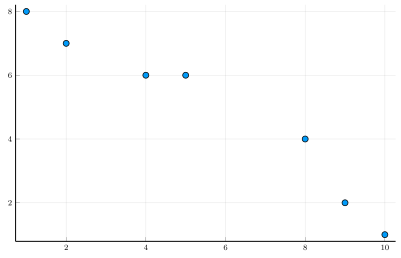

In [31]:
scatter(map(pt->pt[1],pts),map(pt->pt[2],pts),legend=false)

In [32]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model,"print_level",3)
@variable(model,m,start=0)
@variable(model,b,start=0)

@NLobjective(model,Min,  sum((m*pt[1]+b-pt[2])^2 for pt in pts))

In [33]:
optimize!(model)

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 1

                                   (scaled)                 (unscaled)
Objective...............:   7.8374373005015963e-01    2.1317829457364339e+00
Dual infeasibility......:   2.6122894697062509e-14    7.1054273576010019e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP er

In [34]:
value(m),value(b)

(-0.7248062015503876, 8.895348837209301)

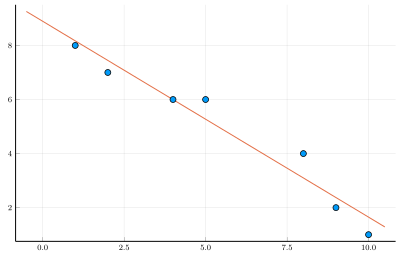

In [35]:
plot!(x->value(m)*x+value(b),-0.5,10.5)

### Fitting to an Exponential Curve

In [44]:
using DataFrames, Query, CSVFiles, StatsPlots

In [45]:
CO2_data = load("../data/co2_annmean_mlo.csv",skiplines_begin=55) |> DataFrame;

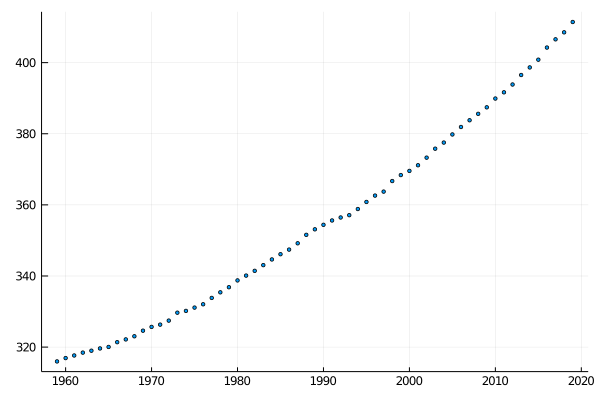

In [46]:
gr()
@df CO2_data scatter(:year,:mean, markersize=2, legend=false)

In [47]:
co2_pts = map(i->(CO2_data[i,:year]-1959,CO2_data[i,:mean]),1:nrow(CO2_data))

61-element Array{Tuple{Int64,Float64},1}:
 (0, 315.97)
 (1, 316.91)
 (2, 317.64)
 (3, 318.45)
 (4, 318.99)
 (5, 319.62)
 (6, 320.04)
 (7, 321.38)
 (8, 322.16)
 (9, 323.04)
 (10, 324.62)
 (11, 325.68)
 (12, 326.32)
 ⋮
 (49, 385.6)
 (50, 387.43)
 (51, 389.9)
 (52, 391.65)
 (53, 393.85)
 (54, 396.52)
 (55, 398.65)
 (56, 400.83)
 (57, 404.24)
 (58, 406.55)
 (59, 408.52)
 (60, 411.43)

In [48]:
model = Model(Ipopt.Optimizer)
set_optimizer_attribute(model,"print_level",5)
@variable(model,C,start=300)
@variable(model,k,start=0.01)

@NLobjective(model,Min,  sum((C*exp(k*pt[1])-pt[2])^2 for pt in co2_pts))
optimize!(model)

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [49]:
value(C),value(k)

(309.65573728266673, 0.0044821320320581485)

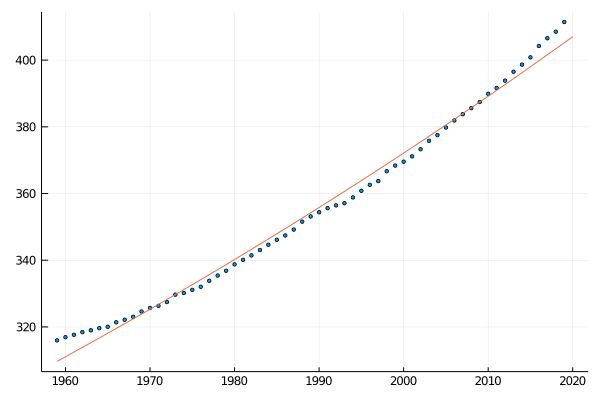

In [50]:
plot!(t->value(C)*exp(value(k)*(t-1959)),1959,2020)

In [52]:
model2 = Model(Ipopt.Optimizer)
set_optimizer_attribute(model2,"print_level",1)
@variable(model2,C,start=100)
@variable(model2,k,start=0.01)
@variable(model2,A,start=100)

@NLobjective(model2,Min,  sum((A+C*exp(k*pt[1])-pt[2])^2 for pt in co2_pts))
optimize!(model2)

In [53]:
value(A),value(C),value(k)

(256.1051371630844, 58.651678745469866, 0.016184448847769144)

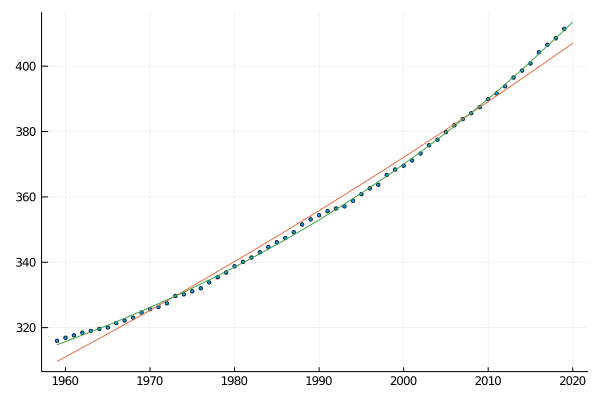

In [54]:
plot!(t->value(A)+value(C)*exp(value(k)*(t-1959)),1959,2020)

In [55]:
using Printf

In [57]:
@sprintf "%7.3f" value(C)

" 58.652"